In [2]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit,  ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import ALAPScheduleAnalysis
from qiskit.transpiler import PassManager
from qiskit import schedule
import csv


In [3]:
## Save your IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="0c58722dfa2bdbbdb16fcd4bd700c0a06c70f31889734b04456cb6b1371576bc8540bc7796fa9f263386274194b24ed63ae4c0a1e749048fd9fdbcef2d4d4eef",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)


In [3]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_sherbrooke")
backend.name

'ibm_sherbrooke'

In [4]:
backend_properties = backend.properties()

# Display the backend properties
print(backend_properties)

In [23]:
qubits_of_interest = range(6)

# Iterate over the specified qubits
for qubit in qubits_of_interest:
    # Retrieve qubit properties
    qubit_props = backend_properties.qubits[qubit]
    
    # Extract T1 and T2 times
    t1 = next(prop.value for prop in qubit_props if prop.name == 'T1')
    t2 = next(prop.value for prop in qubit_props if prop.name == 'T2')
    
    # Retrieve gate properties for single-qubit gates
    for gate in backend_properties.gates:
        if gate.qubits == [qubit]:
            gate_name = gate.gate
            gate_error = next((param.value for param in gate.parameters if param.name == 'gate_error'), None)
            gate_length = next((param.value for param in gate.parameters if param.name == 'gate_length'), None)
            print(f"Qubit {qubit}: Gate {gate_name} - Error: {gate_error}, Duration: {gate_length} seconds")
    
    # Retrieve readout error
    readout_error = backend_properties.readout_error(qubit)
    print(f"Qubit {qubit}: T1 = {t1} µs, T2 = {t2} µs, Readout Error: {readout_error}\n")

Qubit 0: Gate id - Error: 0.0004257752429928325, Duration: 56.888888888888886 seconds
Qubit 0: Gate rz - Error: 0, Duration: 0 seconds
Qubit 0: Gate sx - Error: 0.0004257752429928325, Duration: 56.888888888888886 seconds
Qubit 0: Gate x - Error: 0.0004257752429928325, Duration: 56.888888888888886 seconds
Qubit 0: Gate reset - Error: None, Duration: 1272.888888888889 seconds
Qubit 0: T1 = 443.4700228707058 µs, T2 = 100.56035544142884 µs, Readout Error: 0.009033203125

Qubit 1: Gate id - Error: 0.00011299245385485263, Duration: 56.888888888888886 seconds
Qubit 1: Gate rz - Error: 0, Duration: 0 seconds
Qubit 1: Gate sx - Error: 0.00011299245385485263, Duration: 56.888888888888886 seconds
Qubit 1: Gate x - Error: 0.00011299245385485263, Duration: 56.888888888888886 seconds
Qubit 1: Gate reset - Error: None, Duration: 1272.888888888889 seconds
Qubit 1: T1 = 380.06259214188333 µs, T2 = 352.7259835755397 µs, Readout Error: 0.02294921875

Qubit 2: Gate id - Error: 0.00045395207091845295, Dura

In [24]:
for i in range(5):
    print(backend.qubit_properties(i))

QubitProperties(t1=0.0002139359114739326, t2=0.00010840088977147673, frequency=4635662846.425661)
QubitProperties(t1=0.00034557925792654806, t2=0.0003421926162701377, frequency=4736296869.971339)
QubitProperties(t1=0.0002793149167507507, t2=0.00024867577674362137, frequency=4819178499.281037)
QubitProperties(t1=0.0003716560815777165, t2=0.0003504264375663123, frequency=4747182082.348841)
QubitProperties(t1=0.0003074050519751437, t2=0.00019244484206910214, frequency=4787874618.691494)


In [38]:
backend.target["ecr"][(1, 0)]

InstructionProperties(duration=5.333333333333332e-07, error=0.005237880461401723, calibration=PulseQobj)

In [39]:
print(backend.coupling_map)

[[1, 0], [1, 2], [3, 2], [4, 3], [4, 15], [5, 4], [6, 5], [7, 6], [7, 8], [8, 9], [10, 9], [10, 11], [11, 12], [12, 13], [14, 0], [14, 18], [16, 8], [17, 12], [17, 30], [18, 19], [19, 20], [20, 33], [21, 20], [21, 22], [22, 15], [23, 22], [23, 24], [25, 24], [26, 16], [26, 25], [26, 27], [28, 27], [29, 28], [29, 30], [31, 30], [31, 32], [32, 36], [33, 39], [34, 24], [35, 28], [35, 47], [36, 51], [37, 38], [38, 39], [40, 39], [41, 40], [41, 53], [42, 41], [43, 34], [43, 42], [43, 44], [45, 44], [45, 46], [47, 46], [47, 48], [49, 48], [49, 50], [50, 51], [52, 37], [53, 60], [54, 45], [55, 49], [56, 52], [56, 57], [57, 58], [59, 58], [59, 60], [61, 60], [61, 62], [63, 62], [63, 64], [64, 54], [64, 65], [66, 65], [67, 66], [68, 55], [68, 67], [69, 68], [69, 70], [71, 58], [71, 77], [72, 62], [73, 66], [73, 85], [74, 70], [75, 76], [77, 76], [78, 77], [78, 79], [79, 91], [80, 79], [80, 81], [81, 72], [81, 82], [82, 83], [83, 84], [85, 84], [86, 85], [86, 87], [87, 88], [89, 74], [89, 88], [

In [41]:
target = backend.target
gate_name = 'ecr'  # Replace with the desired gate name

if gate_name in target:
    for qargs, props in target[gate_name].items():
        if props is not None:
            error_rate = props.error
            print(f"Gate: {gate_name}, Qubits: {qargs}, Error Rate: {error_rate}")
        else:
            print(f"Gate: {gate_name}, Qubits: {qargs}, Error Rate: Not available")
else:
    print(f"Gate {gate_name} is not supported on this backend.")


Gate: ecr, Qubits: (1, 0), Error Rate: 0.005237880461401723
Gate: ecr, Qubits: (1, 2), Error Rate: 0.006291406231965557
Gate: ecr, Qubits: (3, 2), Error Rate: 0.007290931769908693
Gate: ecr, Qubits: (4, 3), Error Rate: 0.006660267113239748
Gate: ecr, Qubits: (4, 15), Error Rate: 0.00892090657742306
Gate: ecr, Qubits: (5, 4), Error Rate: 0.01617271500384357
Gate: ecr, Qubits: (6, 5), Error Rate: 0.016745550446861407
Gate: ecr, Qubits: (7, 6), Error Rate: 0.018009870480933166
Gate: ecr, Qubits: (7, 8), Error Rate: 0.044416286482655054
Gate: ecr, Qubits: (8, 9), Error Rate: 0.011498446922727001
Gate: ecr, Qubits: (10, 9), Error Rate: 0.009883645529064844
Gate: ecr, Qubits: (10, 11), Error Rate: 0.003872633163282735
Gate: ecr, Qubits: (11, 12), Error Rate: 0.009454193008059497
Gate: ecr, Qubits: (12, 13), Error Rate: 0.022311327975822526
Gate: ecr, Qubits: (14, 0), Error Rate: 0.005431662543616433
Gate: ecr, Qubits: (14, 18), Error Rate: 0.008570666710058794
Gate: ecr, Qubits: (16, 8), Err

In [ ]:
print("=== ID Gate Duration and Error ===")
if "id" in target:
    # 'id' is typically a single-qubit gate, so keys are likely (0,), (1,), etc.
    for qubit_tuple, props in target["id"].items():
        if props is not None:
            duration = props.duration
            error = props.error
            print(f"Qubit(s) {qubit_tuple}: duration = {duration} s, error = {error}")

=== ID Gate Duration and Error ===
Qubit(s) (0,): duration = 5.6888888888888887e-08 s, error = 0.0001334200523520162
Qubit(s) (1,): duration = 5.6888888888888887e-08 s, error = 0.0002427092957175858
Qubit(s) (2,): duration = 5.6888888888888887e-08 s, error = 0.0002777469919273295
Qubit(s) (3,): duration = 5.6888888888888887e-08 s, error = 0.00014980019658067124
Qubit(s) (4,): duration = 5.6888888888888887e-08 s, error = 0.00016498771583123563
Qubit(s) (5,): duration = 5.6888888888888887e-08 s, error = 0.0008688729537230527
Qubit(s) (6,): duration = 5.6888888888888887e-08 s, error = 0.0008571394124975107
Qubit(s) (7,): duration = 5.6888888888888887e-08 s, error = 0.001493386635195798
Qubit(s) (8,): duration = 5.6888888888888887e-08 s, error = 0.0005850872553505538
Qubit(s) (9,): duration = 5.6888888888888887e-08 s, error = 0.001099561959961644
Qubit(s) (10,): duration = 5.6888888888888887e-08 s, error = 0.00017788418317440696
Qubit(s) (11,): duration = 5.6888888888888887e-08 s, error = 

-code


In [7]:
# scot qreg 
def repetitonCode(backend):
    qreg = QuantumRegister(5, 'q')
    creg = ClassicalRegister(5, 'c')

    qc = QuantumCircuit(qreg, creg)
    qc.x(0)
    qc.barrier()
    qc.cx(qreg[0], qreg[1])
    qc.cx(qreg[0], qreg[2])
    qc.cx(qreg[0], qreg[3])
    qc.cx(qreg[1], qreg[3])
    qc.cx(qreg[1], qreg[4])
    qc.cx(qreg[2], qreg[4])

    qc.barrier()
    for i in range(5):
        qc.measure(i, i)
    
    
    
    display( qc.draw("mpl"))

    pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend,initial_layout= [0,1,2,3,4] )
    transpiled_qc1 = pass_manager.run(qc)
    display( transpiled_qc1.draw("mpl") )
    
    return transpiled_qc1

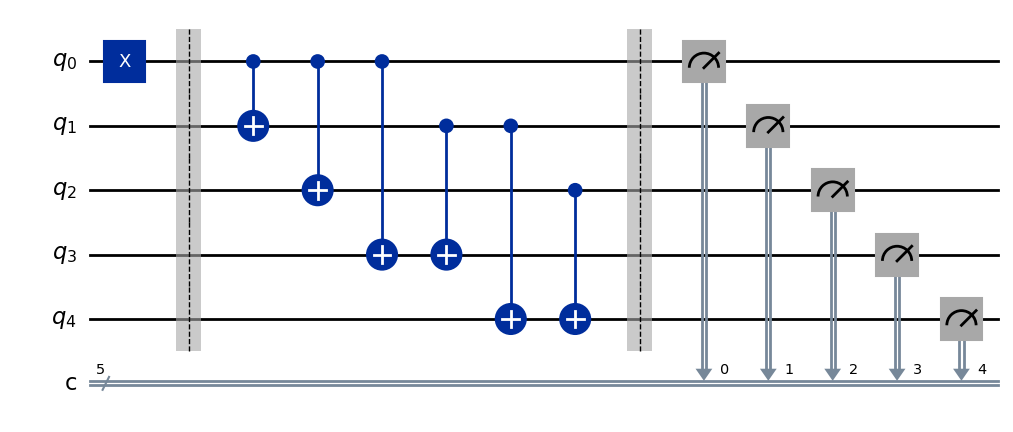

In [8]:
transpiled_qc1 = repetitonCode(backend=backend)

In [10]:
def getExecTime(num_iter, qc):
    exec_time = 0
    for c in range(num_iter):
    
        scheduled_circuit = schedule(qc, backend=backend)
        circuit_duration = scheduled_circuit.duration * backend.configuration().dt    
        exec_time += circuit_duration*1000*1000*1000

    print("execution time    {:}[ns]".format(exec_time/num_iter))

getExecTime(100, transpiled_qc1)

execution time    11896.888888888892[ns]


In [27]:
# 5. Run on real hardware
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_qc1], shots=10000)
print("Job ID:", job.job_id())

result = job.result()[0]

counts = result.join_data().get_counts()


print("Counts from hardware:", counts)



Job ID: cyq2n2cx46r0008xbs70
Counts from hardware: {'00111': 3327, '11010': 520, '00101': 115, '01110': 470, '10011': 1690, '11011': 504, '01100': 17, '10010': 154, '11110': 92, '10101': 184, '01010': 37, '10110': 46, '01101': 73, '11100': 52, '10100': 75, '10111': 490, '01111': 489, '10000': 23, '00110': 214, '11000': 26, '01011': 57, '00011': 289, '00001': 193, '10001': 66, '11101': 363, '00010': 32, '00100': 27, '11111': 123, '11001': 42, '01001': 95, '00000': 88, '01000': 27}


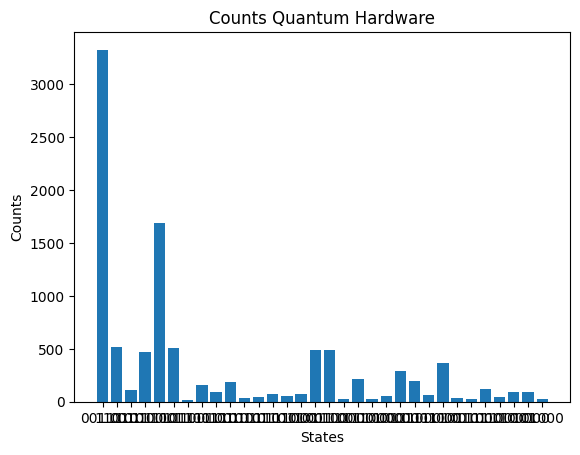

In [ ]:
states = list(counts.keys())
values = list(counts.values())

plt.bar(states, values)
plt.xlabel("States")
plt.ylabel("Counts")
plt.title("Counts Quantum Hardware")
plt.show()

In [31]:
execution_time = result.time_taken
print(f"Execution time: {execution_time} seconds")

AttributeError: 'SamplerPubResult' object has no attribute 'time_taken'

# idGates - part 

In [6]:
def id_gates(backend):
    qcId = QuantumCircuit(127)
    for i in range(188):
        for j in range(127):
            qcId.id(j)
            qcId.barrier(j)
    qcId.measure_all()
    pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend )
    transpiled_qc1 = pass_manager.run(qcId)
    #display( transpiled_qc1.draw("mpl"))
    return transpiled_qc1

In [8]:

qc3 = id_gates(backend)
qc3.draw("mpl")

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

Id Gate duration 56.66 ns<br>
Transpiled Repetition Code duration <br> 
- 11896.8888<br>
- 11911.111111111108[ns]<br>
==> aprox 210 gates ? experimental da altdel :) <br>
cred ca calculeaza si masuratorile 


In [ ]:
getExecTime(10, qc3)

execution time    11911.111111111108[ns]


In [16]:
sampler = Sampler(mode=backend)
job = sampler.run([qc3], shots=10000)
print("Job ID:", job.job_id())

result = job.result()[0]

counts = result.join_data().get_counts()

print("Counts from hardware:", counts)

Job ID: cyrehyzy9d80008d31f0


KeyboardInterrupt: 

# save result into csv based on id of the job

In [4]:
job_id = "cysvxz7q5bwg008s9ck0"  # id for the id baseline with 0 start state 
service = QiskitRuntimeService()

retrieved_job = service.job(job_id)
result = retrieved_job.result()[0]
counts = result.join_data().get_counts()


with open("job_results_from_1.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write a header row
    writer.writerow(["Job ID", "State", "Count"])
    writer.writerow([job_id])
    # Write each state and its corresponding count
    for state, count in counts.items():
        writer.writerow([state, count])



In [2]:
def id_gates_x(backend):
    qcId = QuantumCircuit(5)

    for i in range(5):
        qcId.x(i)
        qcId.barrier(i)

    for i in range(188):
        for j in range(5):
            qcId.id(j)
            qcId.barrier(j)
    qcId.measure_all()
    pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend,initial_layout=[0,1,2,3,4] )
    transpiled_qc1 = pass_manager.run(qcId)
    #display( transpiled_qc1.draw("mpl"))
    return transpiled_qc1

In [ ]:
qc3 = id_gates_x(backend)

sampler = Sampler(mode=backend)
job = sampler.run([qc3], shots=10000)
print("Job ID:", job.job_id())

result = job.result()[0]

counts = result.join_data().get_counts()

print("Counts from hardware:", counts)

with open("job_results_from_1.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Write a header row
    writer.writerow(["Job ID", "State", "Count"])
    writer.writerow([job_id])
    # Write each state and its corresponding count
    for state, count in counts.items():
        writer.writerow([state, count])
# qc3.draw("mpl")

Job ID: cysvxz7q5bwg008s9ck0
